In [1]:
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style='ticks', palette='Paired')
import statsmodels.api as sm
import re
import requests
import math
import numpy as np

C:\Users\tanne\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# NCAA 2017 Wrestling Championships

Wrestling is an interesting sport, because you only compete against individuals in your own weight class. This means that at the end of the year, you have 10 different champions. However, people often wonder and argue who the best wrestler overall was for the year.

Using data from the 2017 NCAA Championsips obtained from [Flowrestling](https://www.flowrestling.org/results/5997906-2017-ncaa-championship-results/4209), we can compare the champions and their results throughout the tournament to see who the most dominant wrestler of the year was.

## Get and Clean the Data

We first need to pull the data from Flowrestling.

In [2]:
url = requests.get('https://www.flowrestling.org/results/5997906-2017-ncaa-championship-results/4209')
text = url.text
soup = BeautifulSoup(text,'lxml')

We then get each of the matches from the table, storing the info in an array. This information includes the weight, winning wrestler and his school, the type of victory, losing wrestler and his school, and the finial result.

In [3]:
matches = []
for match in soup.findAll(['a','br']):
    if re.search('\d{3}',match.text[0:3]) or re.search('\d{3}',str(match.next_sibling)[0:3]):
        if re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',match.text):
            text1 = match.text
        elif re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',str(match.next_sibling)):
            text1 = str(match.next_sibling)
            
        weight = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(1).strip()
        w1 = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(2).strip()
        s1 = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(3).strip()
        dec = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(4).strip()
        w2 = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(5).strip()
        s2 = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(6).strip()
        result = re.search('(\d{3})[\s\S]+?([^\(]+)\(([^\)]+)\) ([A-Z]+) ([^\(]+)\(([^\)]+)\), ([\s\S]+)',text1).group(7).strip()
        
        matches.append([weight, w1, s1, dec, result, 1])
        matches.append([weight, w2, s2, dec, result, 0])        

Now we use pandas to get a first look at the data

In [4]:
names = ['weight', 'name', 'school', 'victory', 'result', 'winner']
data = pd.DataFrame(matches, columns=names)
data = data.drop_duplicates(subset=['weight','name','school','victory','result','winner'])
data.head()

,weight,name,school,victory,result,winner
0,197,J`den Cox,Missouri,DEC,8-2,1
1,197,Brett Pfarr,Minnesota,DEC,8-2,0
2,285,Kyle Snyder,Ohio St.,DEC,6-3,1
3,285,Connor Medbery,Wisconsin,DEC,6-3,0
4,125,Darian Cruz,Lehigh,DEC,6-3,1


We need to make a few binaries for the type of victory, so first we describe the values of the variable, then we define the variables. We also will replace the victory variable with "LOSS" if the wrestler did not win.

In [5]:
data['victory'].loc[data['winner'] == 0] = 'LOSS'
data.victory.value_counts()

LOSS    306
DEC     197
MD       48
F        43
TF       16
Name: victory, dtype: int64

This shows us that 219 matches were won by decision (DEC), meaning that they were decided by less than 8 points, 53 were won by major decision (MD), or were won by more than 8 points but less than 15, 17 by technical fall (TF), meaning 15 or more points, and 46 by fall, meaning that the winner pinned the loser.

In [6]:
data['DEC'] = (data.victory == 'DEC').astype('int')
data['MD'] = (data.victory == 'MD').astype('int')
data['F'] = (data.victory == 'F').astype('int')
data['TF'] = (data.victory == 'TF').astype('int')

Now we get the scores for those who won but did not pin.

In [7]:
data['score'] = np.nan
data['score'].loc[data['winner'] == 1] = data.result.str.extract('(\d+)-',expand=False)
data['score'].loc[data['winner'] == 0] = data.result.str.extract('-(\d+)',expand=False)
data['score'] = (data['score']).astype('float')

C:\Users\tanne\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


A quick sanity check to ensure we did not pick up anything for those matches that pinned.

In [8]:
data.loc[data['victory'] == 'F'].head()

,weight,name,school,victory,result,winner,DEC,MD,F,TF,score
14,165,Vincenzo Joseph,Penn St.,F,5:24,1,0,0,1,0,NaN
22,141,Kevin Jack,North Carolina St.,F,6:22,1,0,0,1,0,NaN
30,184,Tj Dudley,Nebraska,F,2:40,1,0,0,1,0,NaN
32,197,Kollin Moore,Ohio St.,F,2:27,1,0,0,1,0,NaN
40,149,Kenny Theobald,Rutgers,F,2:04,1,0,0,1,0,NaN


Get times for those who pinned and verify it worked correctly. We will write out the times in seconds for usability.

In [9]:
data['times'] = np.nan
data['times'].loc[data['F'] == 1] = (data.result.str.extract('(\d+):',expand=False)).astype('float')*60 + (data.result.str.extract(':(\d+)')).astype('float')
data['times'] = (data['times']).astype('float')
data[['times','result']].loc[data['F'] == 1].head()

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
C:\Users\tanne\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,times,result
14,324.0,5:24
22,382.0,6:22
30,160.0,2:40
32,147.0,2:27
40,124.0,2:04


Now let's see the average score for winners, losers, and the average time to pin.

In [10]:
print('Average winner score: ',round(data['score'].loc[(data['winner'] == 1) & (data['victory'] != 'F') & (data['victory'] != 'LOSS')].mean()))
print('Average loser score: ',round(data['score'].loc[(data['winner'] == 0)].mean()))
print('Average pin time: ',str(math.floor(data['times'].loc[(data['winner'] == 1) & (data['victory'] == 'F')].mean()/60)) + ':' + str(int(round(data['times'].loc[(data['winner'] == 1) & (data['victory'] == 'F')].mean())%60)))

Average winner score:  8
Average loser score:  3
Average pin time:  4:5


We also need to mark who the champions are, since we want to evaluate what the best wrestlers are doing.

In [11]:
data['champ'] = 0
data.loc[[0,2,4,6,8,10,12,14,16,18],'champ'] = 1
data['champ'] = data.groupby(['name'])['champ'].transform(max)

In [12]:
data.groupby(['champ','winner'])['score'].describe()

count      mean       std  min  25%  50%   75%   max
champ winner                                                      
0     0       263.0  2.680608  1.997299  0.0  1.0  2.0   4.0  10.0
      1       232.0  8.008621  4.237527  2.0  5.0  7.0  10.0  25.0
1     1        29.0  8.172414  5.043163  1.0  5.0  6.0  10.0  19.0

In [13]:
data.groupby(['champ','winner'])['times'].describe()

count        mean         std   min     25%    50%     75%  \
champ winner                                                               
0     0         0.0         NaN         NaN   NaN     NaN    NaN     NaN   
      1        38.0  249.263158  137.657955  25.0  132.75  204.5  409.25   
1     1         5.0  212.000000  105.494076  61.0  151.00  247.0  277.00   

                max  
champ winner         
0     0         NaN  
      1       419.0  
1     1       324.0

These tables are interesting because they show us that champions scored almost 0.2 points higher than other winners on average and pinned more than 30 seconds faster on average.

## A Few Descriptive Plots

First we need to see what type of victory each of the champions had. A decision is not as dominant as a major decision, and tech falls/falls are better victories than either of the former.

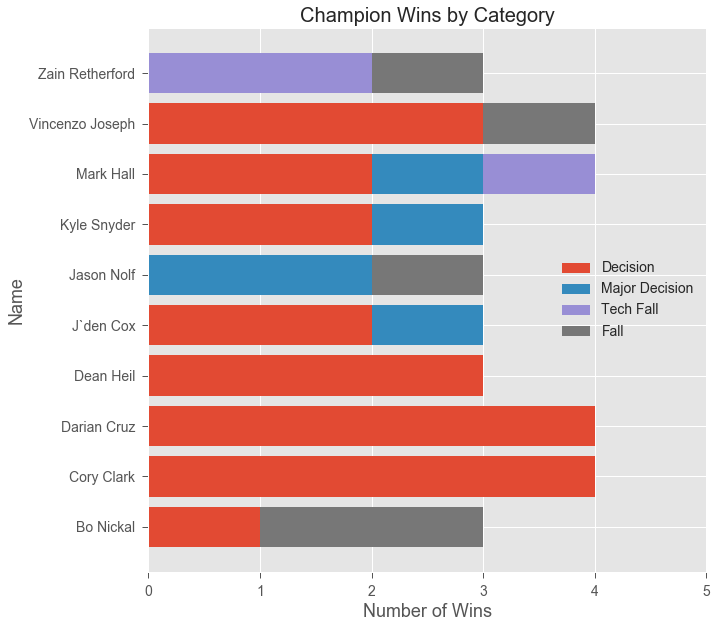

In [14]:
champs = data.loc[data['champ'] == 1]
champs = champs.groupby(['name','weight','victory']).size().to_frame(name='number_matches').reset_index()
champs = champs.pivot(index='name',columns='victory',values='number_matches').reset_index().fillna(0)

width = 0.8

ind = np.arange(10)

mpl.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 10))

p1 = plt.barh(ind, champs.DEC, width, color='C0', left = 0, align='center')
p2 = plt.barh(ind, champs.MD, width, color='C1', left = champs.DEC, align='center')
p3 = plt.barh(ind, champs.TF, width, color='C2', left = champs.DEC + champs.MD, align='center')
p4 = plt.barh(ind, champs.F, width, color='C3', left = champs.DEC + champs.MD + champs.TF, align='center')

plt.ylabel('Name', fontsize=18)
plt.xlabel('Number of Wins', fontsize=18)
plt.title('Champion Wins by Category', fontsize=20)
plt.yticks(ind, ('Bo Nickal',
 'Cory Clark',
 'Darian Cruz',
 'Dean Heil',
 'J`den Cox',
 'Jason Nolf',
 'Kyle Snyder',
 'Mark Hall',
 'Vincenzo Joseph',
 'Zain Retherford'), fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(np.arange(0, 6))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Decision', 'Major Decision', 'Tech Fall', 'Fall'), fontsize = 14, loc=7)

As a decision is a closer match than major, which is closer than a tech fall or a fall, we can see that Zain Retherford, Jason Nolf, and Bo Nickal won more matches by a higher margin. Though we can see how these wrestlers were relative to their weights, we also need to see how tough any given weight was. Maybe one the weight Zain wrestled in was just easier than the others. To investigate this, I plot the number of close matches per weight below.

In [15]:
winners = data.loc[data['winner'] == 1]
winners['point_diff'] = winners.score - (data.result.str.extract('-(\d+)',expand=False)).astype(float)
winners = winners.loc[winners['victory'] == 'DEC']
winners = winners.groupby(['weight','point_diff']).size().to_frame(name='number_matches').reset_index()
winners['label'] = ''

for x in range(10):
    winners['label'].loc[winners['weight'] == winners.weight.unique()[x]] = x

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\tanne\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


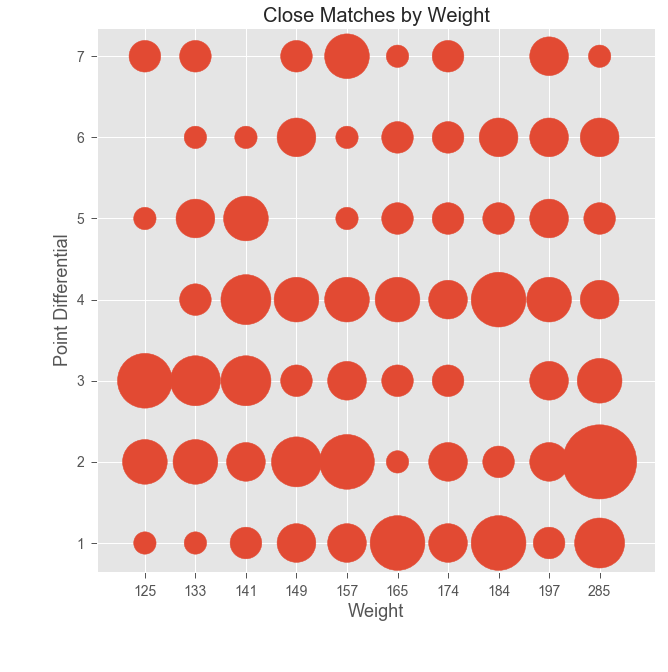

In [20]:
name = list(winners.label)
diff = list(winners.point_diff)
ind = np.arange(10)

mpl.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 10))

plt.title('Close Matches by Weight',fontsize=20)

plt.xlabel('Weight', fontsize=18)
plt.xticks(ind,('125', '133', '141', '149', '157', '165', '174', '184', '197', '285'),fontsize=14)
plt.ylabel('Point Differential', fontsize=18)
plt.yticks(fontsize=14)

plt.annotate('Note: Points are weighted by number of matches with that point differential.', (0,0), (0, -1), fontsize=12)
#.text(name,diff,'Note: Points are weighted by number of matches with that point differential.')

plt.scatter(name,diff,s=winners.number_matches*500)

In [17]:
champ_names = data['name'][data['champ'] == 1].unique()
champ_weights = data['weight'][data['champ'] == 1].unique()

for x in range(len(champ_names)):
    print('Name: ',champ_names[x],'\tWeight: ',champ_weights[x])

Name:  J`den Cox 	Weight:  197
Name:  Kyle Snyder 	Weight:  285
Name:  Darian Cruz 	Weight:  125
Name:  Cory Clark 	Weight:  133
Name:  Dean Heil 	Weight:  141
Name:  Zain Retherford 	Weight:  149
Name:  Jason Nolf 	Weight:  157
Name:  Vincenzo Joseph 	Weight:  165
Name:  Mark Hall 	Weight:  174
Name:  Bo Nickal 	Weight:  184


## Analysis

Though the heavier weights have a higher number of 1 and two point matches, they also have more matches decided in the 4-8 range, suggesting that heavier weights result in a decision more often than the lower weights. This is consistent with convential wisdom. Of matches decided by decision, the lower weights have more very close matches. Since Zain Retherford is a 149 pounder and won all of his matches by fall or technical fall, we will tip the hat to him for best wrestler of the tournament.

# College Scorecard Data

College tuition has been rising precipitously over time, but an important question we can investigate is whether that actually has translated to less students enrolling, staying, and graduating. Using data from the government institution [College Scorecard](https://collegescorecard.ed.gov/data/), we can evaluate this question.

## Get and Clean the Data

I previously downloaded the data, so I will just pull it from the computer.

In [35]:
df = pd.read_csv('C:/Users/tanne/Downloads/CollegeScorecard_Raw_Data/CollegeScorecard_Raw_Data/MERGED2015_16_PP.csv')

C:\Users\tanne\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6,9,1725,1726,1727,1728,1729,1743) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1805 different variables in this data, so we only keep the relevant information.

In [36]:
df.columns = map(str.lower, df.columns)
df = df[['unitid','instnm','city','stabbr','adm_rate','control','curroper','tuitionfee_in','tuitionfee_out','tuitfte','c150_4','ret_ft4','pctfloan',]]
df.head()

,unitid,instnm,city,stabbr,adm_rate,control,curroper,tuitionfee_in,tuitionfee_out,tuitfte,c150_4,ret_ft4,pctfloan
0,100654,Alabama A & M University,Normal,AL,0.6538,1,1,9366.0,17136.0,9657.0,0.3081,0.5779,0.8159
1,100663,University of Alabama at Birmingham,Birmingham,AL,0.6043,1,1,7766.0,17654.0,10263.0,0.5462,0.7864,0.5218
2,100690,Amridge University,Montgomery,AL,NaN,2,1,6900.0,6900.0,17071.0,0.4000,0.6667,0.8781
3,100706,University of Alabama in Huntsville,Huntsville,AL,0.8120,1,1,9128.0,20622.0,8917.0,0.4935,0.8025,0.4589
4,100724,Alabama State University,Montgomery,AL,0.4639,1,1,8720.0,15656.0,7717.0,0.2696,0.6021,0.7692


We will do the analysis separately for private and public institutions, here are some quick descriptive statistics after we rename columns to be a little more informative.

In [42]:
cols = ['id','name','city','stabbr','admission_rate','control','open','tuitionfee_in','tuitionfee_out','tuitrev','completion_rate','retention_rate','pctfloan']
priv = df.loc[df['control'] != 1]
priv.columns = cols
pub = df.loc[df['control'] == 1]
pub.columns = cols
priv.describe()

,id,admission_rate,control,open,tuitionfee_in,tuitionfee_out,tuitrev,completion_rate,retention_rate,pctfloan
count,5.530000e+03,1540.000000,5530.000000,5530.000000,2620.000000,2415.000000,5.145000e+03,1817.000000,1625.000000,4866.000000
mean,2.084735e+06,0.686554,2.637071,0.854430,20418.900382,20951.427743,1.315939e+04,0.484918,0.697905,0.588361
std,7.559712e+06,0.217440,0.480888,0.352706,11009.210947,11217.502284,3.407641e+04,0.230461,0.214592,0.250251
min,1.006900e+05,0.000000,2.000000,0.000000,1488.000000,1488.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.886892e+05,0.551850,2.000000,1.000000,12975.000000,12975.000000,7.777000e+03,0.317900,0.599600,0.478350
50%,3.773285e+05,0.706750,3.000000,1.000000,17252.000000,18000.000000,1.108300e+04,0.473900,0.738900,0.639900
75%,4.570288e+05,0.856175,3.000000,1.000000,27045.500000,27960.000000,1.593700e+04,0.649800,0.836800,0.768125
max,4.862110e+07,1.000000,3.000000,1.000000,73132.000000,73132.000000,2.339300e+06,1.000000,1.000000,1.000000


In [43]:
pub.describe()

,id,admission_rate,control,open,tuitionfee_in,tuitionfee_out,tuitrev,completion_rate,retention_rate,pctfloan
count,2.063000e+03,631.000000,2063.0,2063.000000,1683.000000,1674.000000,1988.000000,672.000000,620.000000,1969.000000
mean,9.106042e+05,0.699465,1.0,0.991760,5324.461676,11997.242533,4607.701207,0.455337,0.748869,0.312600
std,3.819694e+06,0.179285,0.0,0.090424,3264.838377,7335.981956,5495.290703,0.185528,0.110791,0.255393
min,1.006540e+05,0.168800,1.0,0.000000,580.000000,580.000000,0.000000,0.045200,0.377100,0.000000
25%,1.553580e+05,0.585400,1.0,1.000000,2979.000000,6493.500000,1731.750000,0.323025,0.677800,0.055500
50%,1.991930e+05,0.724100,1.0,1.000000,4340.000000,9454.000000,3181.000000,0.439150,0.753550,0.298900
75%,2.366740e+05,0.828850,1.0,1.000000,7049.000000,16397.250000,6076.500000,0.577575,0.825325,0.513700
max,4.579430e+07,1.000000,1.0,1.000000,19372.000000,44365.000000,98584.000000,0.933000,1.000000,0.988800


Generally it looks individuals at public schools pay much less tuition, especially if they are in-state students, are slightly less likely to complete a degree but slightly more likely to be retained as a first-year student, and utilize federal loans at a much lower rate than those at private schools. Also, public schools make much less money off of tuition than private schools.

Now that we have gotten a general feel for the data, we will make sure that the schools in our sample are in operation and only keep four-year institutions.

In [46]:
priv = priv[(priv['open'] == 1) & (priv['completion_rate'].notnull())]
pub = pub[(pub['open'] == 1) & (pub['completion_rate'].notnull())]

Let's also make bins of the highest in-state tuition, out of state tuition, and tuition revenue.

In [70]:
priv['tuit_in_bin'] = pd.qcut(priv['tuitionfee_in'],10,labels=False)
priv['tuit_out_bin'] = pd.qcut(priv['tuitionfee_out'],10,labels=False)
priv['tuit_rev_bin'] = pd.qcut(priv['tuitrev'],10,labels=False)

pub['tuit_in_bin'] = pd.qcut(pub['tuitionfee_in'],10,labels=False)
pub['tuit_out_bin'] = pd.qcut(pub['tuitionfee_out'],10,labels=False)
pub['tuit_rev_bin'] = pd.qcut(pub['tuitrev'],10,labels=False)

Now we can see some information based on our bins.

In [71]:
priv[['tuit_in_bin','admission_rate','completion_rate','retention_rate','pctfloan']].groupby(['tuit_in_bin']).mean()

,admission_rate,completion_rate,retention_rate,pctfloan
tuit_in_bin,,,,
0.0,0.685230,0.384402,0.665552,0.309028
1.0,0.747324,0.325587,0.592393,0.545430
2.0,0.692103,0.376552,0.599250,0.682736
3.0,0.648760,0.382691,0.611719,0.735835
4.0,0.689225,0.451784,0.658145,0.645469
5.0,0.688417,0.489344,0.703256,0.689635
6.0,0.666999,0.534335,0.739387,0.682811
7.0,0.712695,0.592728,0.767638,0.660435
8.0,0.688226,0.664157,0.821788,0.619788


In [72]:
priv[['tuit_out_bin','admission_rate','completion_rate','retention_rate','pctfloan']].groupby(['tuit_out_bin']).mean()

,admission_rate,completion_rate,retention_rate,pctfloan
tuit_out_bin,,,,
0.0,0.682094,0.381363,0.657965,0.309609
1.0,0.749409,0.328513,0.600369,0.544871
2.0,0.692103,0.376552,0.599250,0.682736
3.0,0.648760,0.382691,0.611719,0.735835
4.0,0.689225,0.451784,0.658145,0.645469
5.0,0.688417,0.489344,0.703256,0.689635
6.0,0.666999,0.534335,0.739387,0.682811
7.0,0.712695,0.592728,0.767638,0.660435
8.0,0.688226,0.664157,0.821788,0.619788


In [73]:
priv[['tuit_rev_bin','admission_rate','completion_rate','retention_rate','pctfloan']].groupby(['tuit_rev_bin']).mean()

,admission_rate,completion_rate,retention_rate,pctfloan
tuit_rev_bin,,,,
0,0.651815,0.420492,0.679162,0.360206
1,0.666183,0.385174,0.623679,0.527382
2,0.669578,0.414878,0.634873,0.658198
3,0.688102,0.464399,0.665082,0.673637
4,0.647530,0.484710,0.693549,0.695701
5,0.722996,0.449679,0.704095,0.703352
6,0.678602,0.508531,0.718386,0.678176
7,0.731595,0.519771,0.732179,0.646107
8,0.657224,0.633983,0.799714,0.580282


In [74]:
pub[['tuit_in_bin','admission_rate','completion_rate','retention_rate','pctfloan']].groupby(['tuit_in_bin']).mean()

,admission_rate,completion_rate,retention_rate,pctfloan
tuit_in_bin,,,,
0,0.600059,0.294859,0.744100,0.184231
1,0.751654,0.278176,0.651088,0.346315
2,0.637704,0.348496,0.690021,0.537722
3,0.649725,0.452003,0.756186,0.424442
4,0.746926,0.397233,0.695706,0.506810
5,0.720627,0.484822,0.746557,0.557915
6,0.701696,0.516270,0.763334,0.543603
7,0.739592,0.540349,0.771400,0.578151
8,0.724318,0.591533,0.807927,0.544646


In [75]:
pub[['tuit_out_bin','admission_rate','completion_rate','retention_rate','pctfloan']].groupby(['tuit_out_bin']).mean()

,admission_rate,completion_rate,retention_rate,pctfloan
tuit_out_bin,,,,
0,0.668448,0.293222,0.709787,0.227071
1,0.757668,0.305985,0.639408,0.360758
2,0.654351,0.335224,0.677429,0.446960
3,0.736990,0.404561,0.713952,0.573082
4,0.642098,0.434625,0.738910,0.540924
5,0.710864,0.472101,0.740122,0.539355
6,0.733561,0.462346,0.737757,0.561340
7,0.755561,0.543884,0.781236,0.563463
8,0.718505,0.558794,0.796143,0.536588


In [78]:
pub[['tuit_rev_bin','admission_rate','completion_rate','retention_rate','pctfloan']].groupby(['tuit_rev_bin']).mean()

,tuitrev,admission_rate,completion_rate,retention_rate,pctfloan
tuit_rev_bin,,,,,
0,1503.970588,0.583458,0.308066,0.707006,0.186022
1,3181.597015,0.688032,0.275978,0.666931,0.429633
2,4438.447761,0.672641,0.379239,0.724027,0.457270
3,5257.656716,0.732436,0.413479,0.702697,0.489236
4,5917.462687,0.690686,0.453725,0.731720,0.559884
5,6584.059701,0.691812,0.449540,0.728697,0.531737
6,7356.925373,0.709948,0.486140,0.748422,0.570188
7,8514.149254,0.749411,0.511204,0.773530,0.551196
8,10655.223881,0.755015,0.559740,0.793170,0.532679


Interestingly, in every case, we see no clear trend in admission, but completion and retention appear to be increasing with in-state tuition, out of state tuition, and tuition revenue at both public and private schools. There is also no clear trend in the percent of students receiving federal loans.